# COSE474-2024F : Deep Learning HW2

**Name**: Song Sanghwa. **Department**: Statistics. **Student ID**: 2019150470


In [ ]:
!pip install d2l==1.0.3

# 7. Convolutional Neural Networks

## 7.1. From Fully Connected Layers to Convolutions

## 7.2. Convolutions for Images

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.2.1. The Cross-Correlation Operation

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 7.2.2. Convolutional Layers



In [ ]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 7.2.3. Object Edge Detection in Images

In [ ]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [ ]:
K = torch.tensor([[1.0, -1.0]])

In [ ]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [ ]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 7.2.4. Learning a Kernel

In [ ]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example, channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2  # Learning rate

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 7.417
epoch 4, loss 1.273
epoch 6, loss 0.225
epoch 8, loss 0.042
epoch 10, loss 0.009


In [ ]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9800, -0.9919]])

### 7.2.5. Cross-Correlation and Convolution

### 7.2.6. Feature Map and Receptive Field

### 7.2.7. Summary

## 7.3 Padding and Stride

In [ ]:
import torch
from torch import nn

In [ ]:
# We define a helper function to calculate convolutions. It initializes the
# convolutional layer weights and performs corresponding dimensionality
# elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    # (1, 1) indicates that batch size and the number of channels are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Strip the first two dimensions: examples and channels
    return Y.reshape(Y.shape[2:])

# 1 row and column is padded on either side, so a total of 2 rows or columns
# are added
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
# We use a convolution kernel with height 5 and width 3. The padding on either
# side of the height and width are 2 and 1, respectively
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [ ]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

## 7.4. Multiple Input and Multiple Output Channels

In [ ]:
import torch
from d2l import torch as d2l

In [ ]:
def corr2d_multi_in(X, K):
    # Iterate through the 0th dimension (channel) of K first, then add them up
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [ ]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [ ]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [ ]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [ ]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 7.4.3. Convolutional Layer

In [ ]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # Matrix multiplication in the fully connected layer
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [ ]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

## 7.5. Pooling

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

### 7.5.1. Maximum Pooling and Average Pooling

In [ ]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

In [ ]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [ ]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 7.5.2. Padding and Stride

In [ ]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [ ]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 7.5.3. Multiple Channels

In [ ]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [ ]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## 7.6. Convolutional Neural Networks (LeNet)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
    """The LeNet-5 model."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

In [ ]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


### 7.6.2. Training

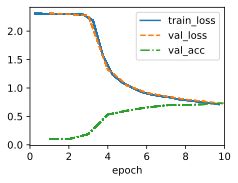

In [ ]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

# 8. Modern Convolutional Neural Networks

## 8.2. Networks Using Blocks (VGG)

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

In [ ]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 8.2.3. Training

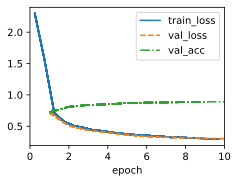

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

### 8.2.2. VGG Network

## 8.6. Residual Networks (ResNet) and ResNeXt

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [ ]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

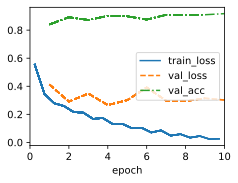

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

# Discussion & Exercises

### 7.1.6.2. Exercises
Audio data is often represented as a one-dimensional sequence. When might you want to impose locality and translation invariance for audio?

- Locality refers to focusing on small, local segments of the audio. We can use local features like phonemes, notes, or chords in music. We can use tone and pitch of specific speaker in dialogue. Translation invariance refers to recognizing patterns regardless of their position within the overall time sequence. Often times we have to recognize these local features regardless of their position, so translation invariance occurs.

Derive the convolution operations for audio. Can you treat audio using the same tools as computer vision? Hint: use the spectrogram.
- Raw audio data can be represented as a 1D signal. We can convert a raw audio waveform into a spectrogram, which is a 2D time-frequency representation. This transformation allows us to leverage 2D convolutional neural networks.

Do you think that convolutional layers might also be applicable for text data? Which problems might you encounter with language?
- The convolutional layers may fail to capture the sequential structure text data have. And text data often have variable length, which makes it difficult to be handled by convolutional layer. But there are many clever structures in NLP that leverages computer vision tools like CNN overcoming these challenges.



### 7.2.7. Memo
In terms of convolutions themselves, they can be used for many purposes, for example detecting edges and lines, blurring images, or sharpening them. Most importantly, it is not necessary that the statistician (or engineer) invents suitable filters. Instead, we can simply learn them from data. This replaces feature engineering heuristics by evidence-based statistics. Lastly, and quite delightfully, these filters are not just advantageous for building deep networks but they also correspond to receptive fields and feature maps in the brain. This gives us confidence that we are on the right track.

### 7.2 Discussion

What heuristic fillters were developed so far?
- Box Filter: A box filter replaces each pixel value in the image with the average value of its neighboring pixels to blur the image.

- Sobel Filter: The Sobel filter applies a convolution to approximate the gradient of the image intensity function to detect the edge.

- FAST (Features from Accelerated Segment Test): FAST detects corners in an image by comparing the brightness of a pixel to its surrounding circle of pixels.

- ...

### 7.3.3.4 - 7.3.3.6 Exercises

What are the computational benefits of a stride larger than 1?
- Wider stride reduces the size of the output feature map, making the computation much faster and less memory-intensive.

What might be statistical benefits of a stride larger than 1?
- Since adjacent pixels share almost the same properties, correlation can be reduced by downsampling with wider stride. We can focus more on distinct features.

How would you implement a stride of 0.5? What does it correspond to? When would this be useful?
- This is like a supersampling. We have to enlarge the image and interpolate the gaps.

### 7.3. Discussion
Is there a fast way to calculate convolution in CNN?

- Since convolution can be performed as a matrix multiplication, we can increase the computational efficiency by using various methods used to perform matrix operations efficiently.

- Efficient matrix multiplication algorithm, Hardware Accelerations, ...

- I'm not sure we can leverage FFT in 2D convolution. It may cause an overhead since kernel size is usually not that large.


### 7.4.5.2. Exercises
Assume an input of shape $ c_{i} \times h \times w $ and a convolution kernel of shape $ c_{o} \times c_{i} \times k_{h} \times k_{w} $, padding of $(p_{h}, p_{w})$, and stride of $s_{h}, s_{w}$. What is the computational cost (multiplications and additions) for the forward propagation?

- For each output element, the number of multiplications is $ c_{i} \times k_{h} \times k_{w} $.

- We have $ H_{o} \times W_{o} $ elements for one output feature, where
$ H_{o} = \cfrac {h - k_{h} + 2 \cdot p_{h} + s_{h}} {s_{h}} $, $ W_{o} = \cfrac {w - k_{w} + 2 \cdot p_{w} + s_{w}} {s_{w}} $.

- We have $c_{o}$ outputs total.

- Therefore, the number of multiplication is $ c_{o} \times H_{o} \times W_{o} \times c_{i} \times k_{h} \times k_{w} $ .

- Likewise, the number of addition is $ c_{o} \times H_{o} \times W_{o} \times (c_{i} \times k_{h} \times k_{w} - 1) $ . There are $ (c_{i} \times k_{h} \times k_{w}) $ values to sum for $ c_{o} \times H_{o} \times W_{o} $ times.


### 7.5 Discussion
Are there any other pooling functions which is not introduced in the chapter?

- Lp Pooling - Lp pooling is a generalization of both max and average pooling, with a parameter $p$.

- Stochastic Pooling - Stochastic pooling introduces randomness into the pooling process by sampling values from the pooling window based on their magnitude. Larger values have a higher probability of being selected. But it increases computational complexity and makes inconsistent behavior in inference.


### 8.2. Memo

- The key idea of Simonyan and Zisserman (2014) was to use multiple convolutions in between downsampling via max-pooling in the form of a block. They were primarily interested in whether deep or wide networks perform better. For instance, the successive application of two
 convolutions touches the same pixels as a single
 convolution does. At the same time, the latter uses approximately as many parameters as three convolutions do. In a rather detailed analysis they showed that deep and narrow networks significantly outperform their shallow counterparts. This set deep learning on a quest for ever deeper networks with over 100 layers for typical applications. Stacking
 convolutions has become a gold standard in later deep networks (a design decision only to be revisited recently by Liu et al. (2022)). Consequently, fast implementations for small convolutions have become a staple on GPUs (Lavin and Gray, 2016).

### 8.2. Exercises

How many parameters does the **VGG-11** has?

Arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

- The number of parameters for a convolutional layer is given by:
$$ (\text{input channels} \times \text{filter height} \times \text{filter width} + \text{bias}) \times \text{output channels} $$

1. convolution layer with 064 channel:
$ (3 \times 3 \times 3 + 1) \times 64 $

2. convolution layer with 128 channel:
$ (64 \times 3 \times 3 + 1) \times 128 $

3. convolution layer with 256 channel:
$ (128 \times 3 \times 3 + 1) \times 256 $

4. convolution layer with 256 channel:
$ (256 \times 3 \times 3 + 1) \times 256 $

5. convolution layer with 512 channel:
$ (256 \times 3 \times 3 + 1) \times 512 $

6. convolution layer with 512 channel:
$ (512 \times 3 \times 3 + 1) \times 512 $

7. convolution layer with 512 channel:
$ (512 \times 3 \times 3 + 1) \times 512 $

8. convolution layer with 512 channel:
$ (512 \times 3 \times 3 + 1) \times 512 $

- The number of parameters for a fully connected layer is given by:
$ (\text{input neurons} + \text{bias}) \times \text{output neurons} $

1. FC layer 1:
$ (25088 + 1) \times 4096 $

2. FC layer 2:
$ (4096 + 1) \times 4096 $

3. FC layer 3:
$ (4096 + 1) \times 10 $

Sum of the parameters in each layer gives the number of total parameters.

### 8.6. Memo

- The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero. We can train an effective deep neural network by having residual blocks. Inputs can forward propagate faster through the residual connections across layers. As a consequence, we can thus train much deeper networks.

- the Transformer architecture (Vaswani et al., 2017) adopts residual connections (together with other design choices) and is pervasive in areas as diverse as language, vision, speech, and reinforcement learning.

### 8.6. Discussion

How the ResNet influenced to other deep learning models?

- ResNet revolutionized the design of deep neural networks by addressing the challenges of training very deep networks known as **vanishing gradient problem**. Residual connection enabled the creation of extremely deep networks and it has become standard. It has also had a huge impact on other areas beyond computer vision.


### 8.6.7.1 Exercises

What are the major differences between the Inception block and the residual block? How do they compare in terms of computation, accuracy, and the classes of functions they can describe?

- **The Inception block** is designed to capture multi-scale features efficiently by applying multiple convolutions of different kernel sizes. These different kernels allow the network to capture both fine details and larger context.

- **The Residual block** addresses the vanishing gradient problem in very deep networks with skip connection. It simplifies the training of very deep networks by making it easier to propagate information and gradients across many layers.

- ResNet later outperformed GoogLeNet in very deep configurations.